In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

- https://www.youtube.com/watch?v=ElmBrKyMXxs
- https://github.com/hans/ipython-notebooks/blob/master/tf/TF%20tutorial.ipynb
- https://github.com/ematvey/tensorflow-seq2seq-tutorials

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from models.price_history_seq2seq import PriceHistorySeq2Seq
from cost_functions.huber_loss import huber_loss
from os.path import isdir

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

In [4]:
data_folder = '../../../../Dropbox/data'
assert isdir(data_folder)

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [5]:
num_epochs = 10

num_features = 1
num_units = 400 #state size

input_len = 60
target_len = 30

batch_size = 47

#trunc_backprop_len = ??

### Step 1 - collect data (and/or generate them)

In [6]:
npz_path = '../price_history_03_dp_60to30_from_fixed_len.npz'

In [7]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_path, batch_size=batch_size)
dp.inputs.shape, dp.targets.shape

((11374, 60, 1), (11374, 30))

In [8]:
aa, bb = dp.next()
aa.shape, bb.shape

((47, 60, 1), (47, 31))

### Step 2 - Build model

```
PriceHistoryDummySeq2Seq(rng=random_state, dtype=dtype, config=config).getGraph(batch_size=batch_size,
                       num_units=num_units,
                       input_len=input_len,
                       target_len=target_len)
learning rate: 0.001000
60
Tensor("inputs/unstack:0", shape=(47, 1), dtype=float32)

Tensor("encoder_rnn_layer/rnn/basic_rnn_cell_59/Tanh:0", shape=(47, 400), dtype=float32)

decoder inputs series
<type 'list'>
30
Tensor("decoder_rnn_layer/unstack:0", shape=(47, 1), dtype=float32)

30
Tensor("decoder_rnn_layer/rnn/basic_rnn_cell/Tanh:0", shape=(47, 400), dtype=float32)

30
Tensor("readout_layer/add:0", shape=(47, 1), dtype=float32)

Tensor("predictions/Reshape:0", shape=(47, 30), dtype=float32)

Tensor("error/Select:0", shape=(47, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
```

In [9]:
model = PriceHistorySeq2Seq(rng=random_state, dtype=dtype, config=config)

In [10]:
# graph = model.getGraph(batch_size=batch_size,
#                        num_units=num_units,
#                        input_len=input_len,
#                        target_len=target_len)

learning rate: 0.001000
60
Tensor("inputs/unstack:0", shape=(47, 1), dtype=float32)

Tensor("encoder_rnn_layer/rnn/basic_rnn_cell_59/Tanh:0", shape=(47, 400), dtype=float32)

time: Tensor("decoder_rnn_layer/rnn/while/add:0", shape=(), dtype=int32)

<tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7fc5424ef090>

Tensor("decoder_rnn_layer/decoder_out_tensor/decoder_out_tensor:0", shape=(?, 47, 400), dtype=float32)

Tensor("readout_layer/readouts:0", shape=(?, 1), dtype=float32)

Tensor("predictions/Reshape:0", shape=(31, 47), dtype=float32)
Tensor("predictions/transpose:0", shape=(47, 31), dtype=float32)

Tensor("error/Select:0", shape=(47, 31), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)

In [11]:
#show_graph(graph)

#### Conclusion
There is no way this graph makes much sense but let's give it a try to see how bad really is

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

## GRU cell - with EOS = 1000 - 200 epochs

In [12]:
rnn_cell = PriceHistorySeq2Seq.RNN_CELLS.GRU
num_epochs = 200
num_epochs, num_units, batch_size

(200, 400, 47)

In [13]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [15]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='006_gru_seq2seq_EOS1000_200epochs_60to30',
                                     nn_runs_folder= data_folder + '/nn_runs')

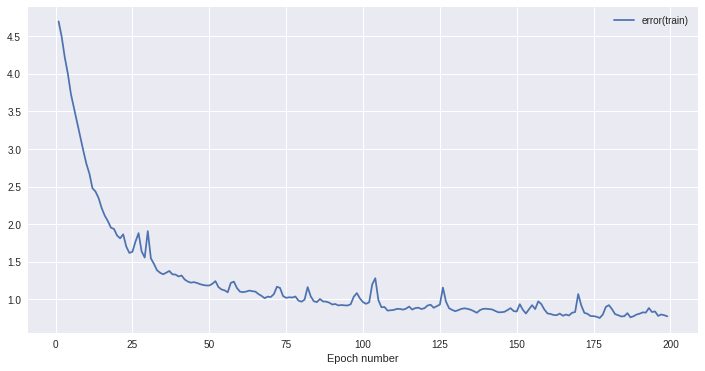

In [16]:
dyn_stats.plotStats()
plt.show()

In [17]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [18]:
ind = np.argmin(r2_scores)
ind

3918

In [19]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [20]:
r2_score(y_true=reals, y_pred=preds)

-4.2469098837878091e+29

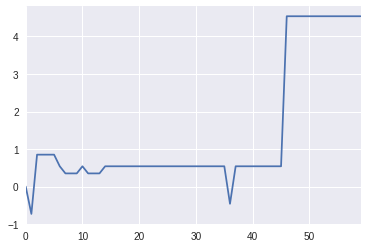

In [21]:
sns.tsplot(data=dp.inputs[ind].flatten())

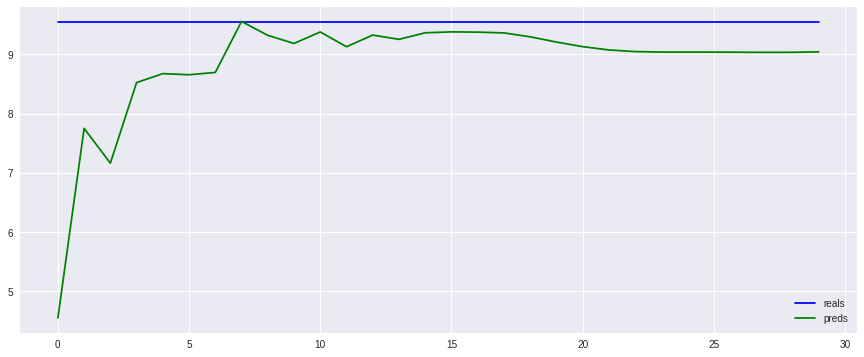

In [22]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [23]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23 s, sys: 132 ms, total: 23.1 s
Wall time: 22.9 s


In [24]:
np.mean(dtw_scores)

24.855095998112979

In [25]:
coint(preds, reals)

(-3.2066807773762358,
 0.068817644116674015,
 array([-4.31395736, -3.55493606, -3.19393252]))

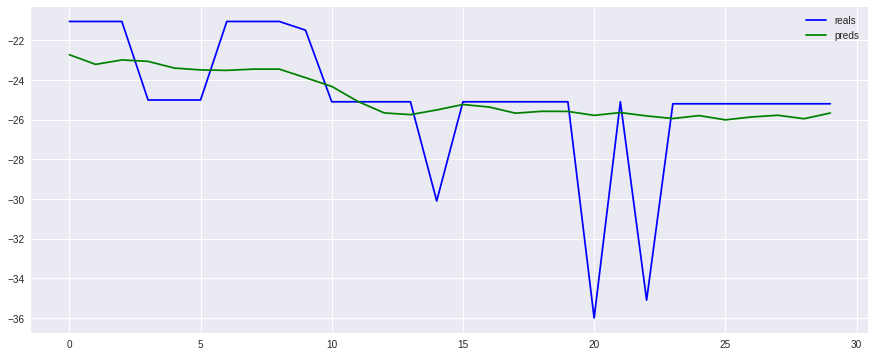

In [31]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [27]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss

0.70332579602907797

#### Conclusion
???

## Basic RNN cell (EOS 1000)

In [11]:
rnn_cell = PriceHistorySeq2Seq.RNN_CELLS.BASIC_RNN
num_epochs = 10
num_epochs, num_units, batch_size

(10, 400, 47)

In [12]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [13]:
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='006_basic_rnn_seq2seq_EOS1000_60to30')

#### Conclusion
It is ~40% extra time, it is slower.
It's not as bad as I had originally imagined but it is pretty bad because it is above 4. This is above baseline!

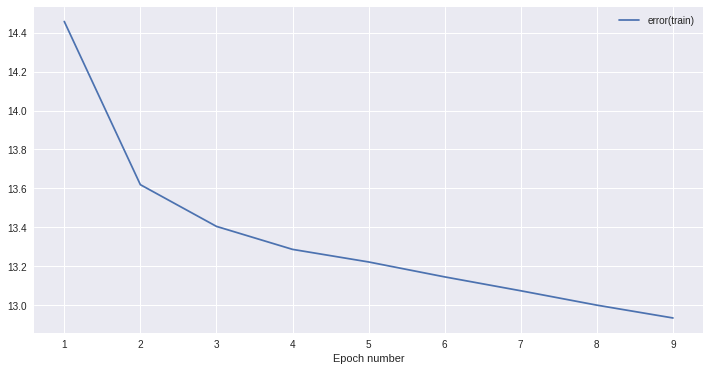

In [14]:
dyn_stats.plotStats()
plt.show()

In [15]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [16]:
ind = np.argmin(r2_scores)
ind

3918

In [17]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [18]:
r2_score(y_true=reals, y_pred=preds)

-5.6570555108860513e+31

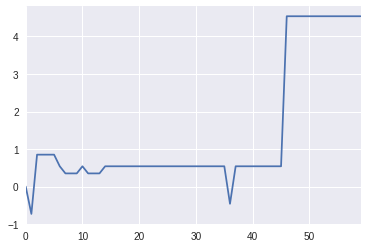

In [19]:
sns.tsplot(data=dp.inputs[ind].flatten())

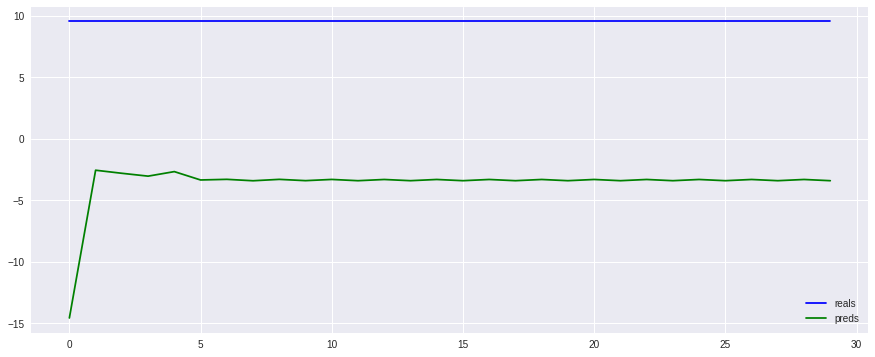

In [20]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [21]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23.6 s, sys: 108 ms, total: 23.7 s
Wall time: 23.4 s


In [22]:
np.mean(dtw_scores)

411.24033794715154

In [23]:
coint(preds, reals)

(0.15439039461030454,
 0.98890988306012451,
 array([-4.31395736, -3.55493606, -3.19393252]))

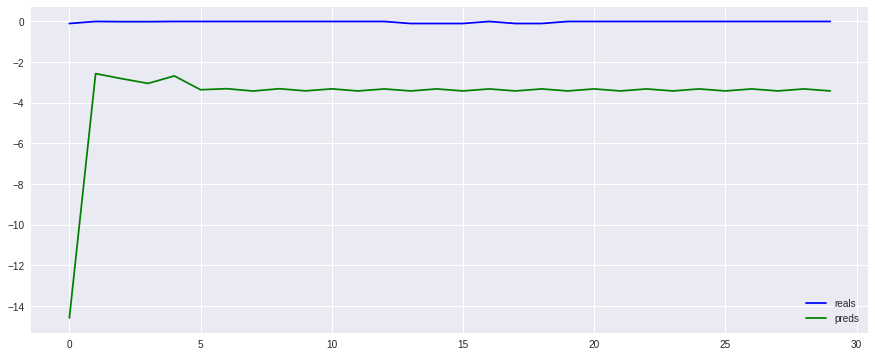

In [24]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
The observation of this architecture is that it is quite stable, we don't have much dynamic behavior to the target month

## GRU cell - with EOS = 1000

In [25]:
rnn_cell = PriceHistorySeq2Seq.RNN_CELLS.GRU
num_epochs = 10
num_epochs, num_units, batch_size

(10, 400, 47)

In [26]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [27]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='006_gru_seq2seq_EOS1000_60to30')

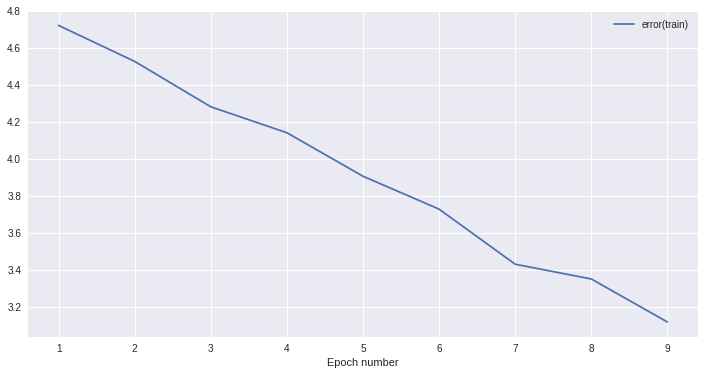

In [28]:
dyn_stats.plotStats()
plt.show()

In [29]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [30]:
ind = np.argmin(r2_scores)
ind

2685

In [31]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [32]:
r2_score(y_true=reals, y_pred=preds)

-2.4241887490466177e+31

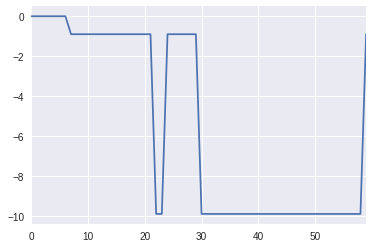

In [33]:
sns.tsplot(data=dp.inputs[ind].flatten())

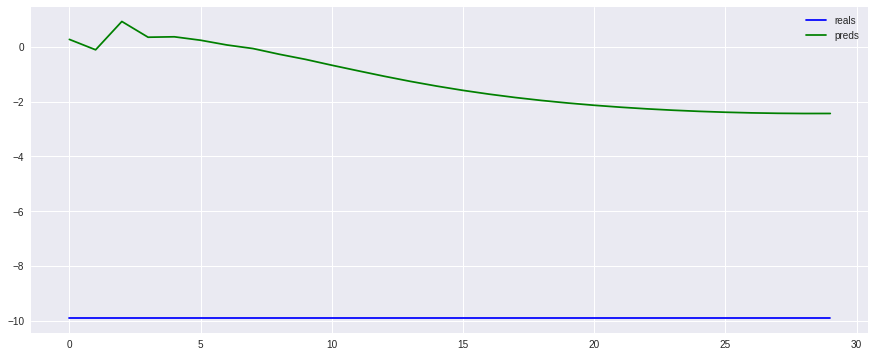

In [34]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [35]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23.7 s, sys: 148 ms, total: 23.9 s
Wall time: 23.6 s


In [36]:
np.mean(dtw_scores)

91.309774408071476

In [37]:
coint(preds, reals)

(-18.51320070295068,
 1.4136041816365899e-29,
 array([-4.31395736, -3.55493606, -3.19393252]))

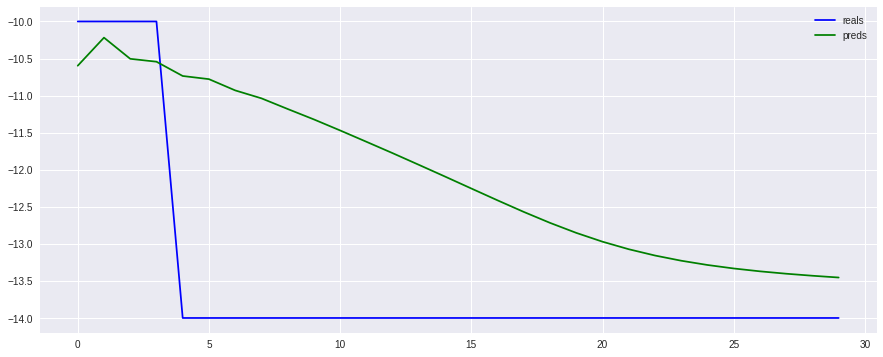

In [38]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

#### Conclusion
???

## Basic RNN cell (EOS 0)

In [39]:
rnn_cell = PriceHistorySeq2Seq.RNN_CELLS.BASIC_RNN
num_epochs = 10
num_epochs, num_units, batch_size

(10, 400, 47)

In [40]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
        eos_token = 0
    )

In [41]:
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='006_basic_rnn_seq2seq_zeroEOS_60to30')

#### Conclusion
???

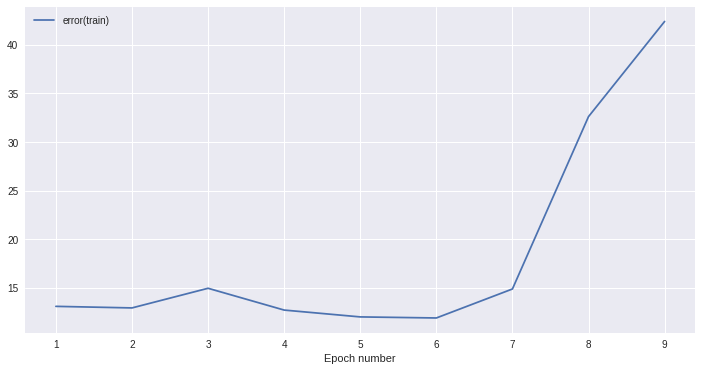

In [42]:
dyn_stats.plotStats()
plt.show()

In [43]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [44]:
ind = np.argmin(r2_scores)
ind

1486

In [45]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [46]:
r2_score(y_true=reals, y_pred=preds)

-9.9589906125430667e+32

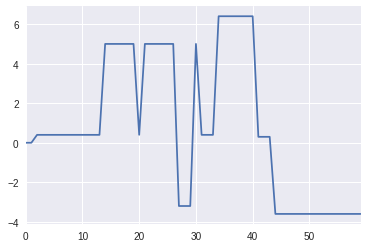

In [47]:
sns.tsplot(data=dp.inputs[ind].flatten())

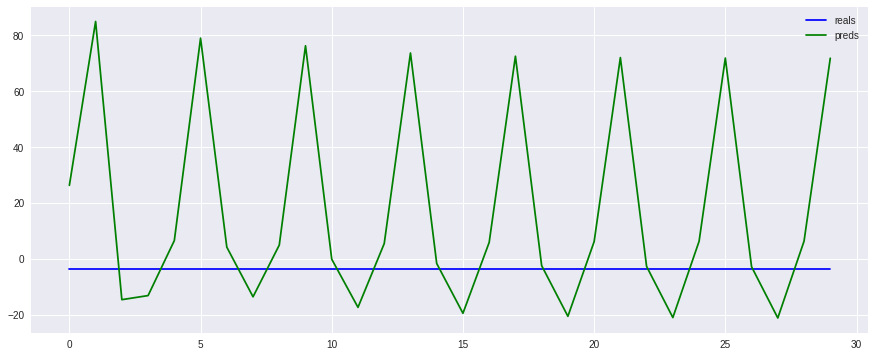

In [48]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [49]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 23.5 s, sys: 100 ms, total: 23.6 s
Wall time: 23.4 s


In [50]:
np.mean(dtw_scores)

1027.9909013681649

In [51]:
coint(preds, reals)

(-0.51826090757079113,
 0.96300586405041622,
 array([-4.31395736, -3.55493606, -3.19393252]))

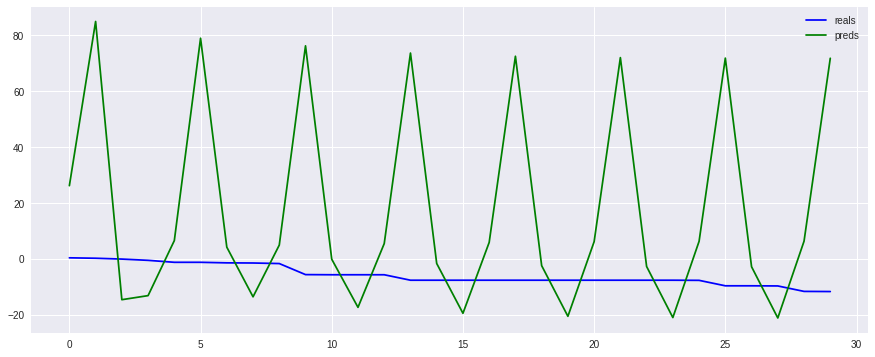

In [52]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
It is oscillating which is an indication that setting EOS to zero where the real values is not helping the model

Perhaps another idea is to have as first input of the decoder RNN the latest value of the encoding stream

## GRU cell - with EOS = 0

In [53]:
rnn_cell = PriceHistorySeq2Seq.RNN_CELLS.GRU
num_epochs = 10
num_epochs, num_units, batch_size

(10, 400, 47)

In [54]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
        eos_token = 0,
    )

In [55]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='006_gru_seq2seq_zeroEOS_60to30')

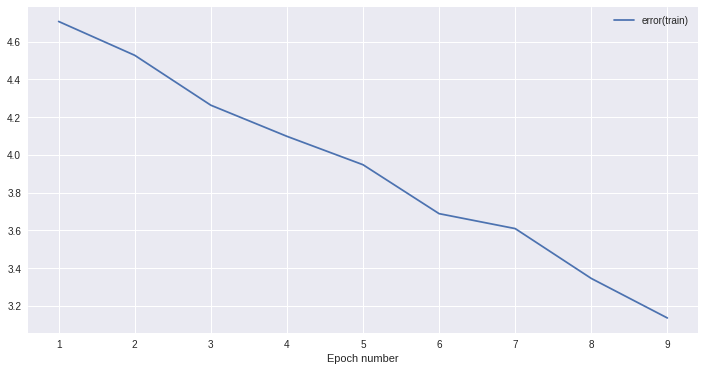

In [56]:
dyn_stats.plotStats()
plt.show()

In [57]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [58]:
ind = np.argmin(r2_scores)
ind

2685

In [59]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [60]:
r2_score(y_true=reals, y_pred=preds)

-2.6018017230166582e+31

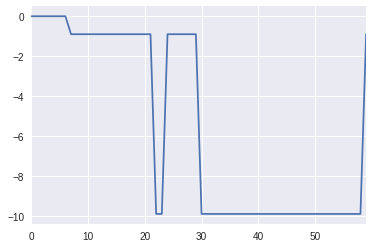

In [61]:
sns.tsplot(data=dp.inputs[ind].flatten())

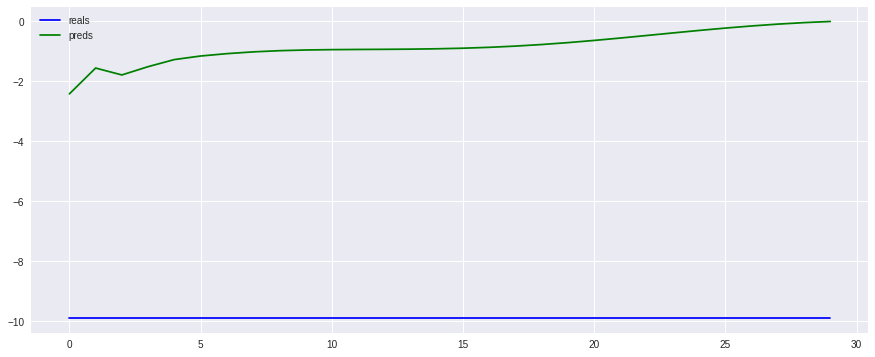

In [62]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [63]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 24.1 s, sys: 164 ms, total: 24.2 s
Wall time: 23.9 s


In [64]:
np.mean(dtw_scores)

93.04125203737857

In [65]:
coint(preds, reals)

(-5.756727854620225,
 5.3341783987358949e-06,
 array([-4.31395736, -3.55493606, -3.19393252]))

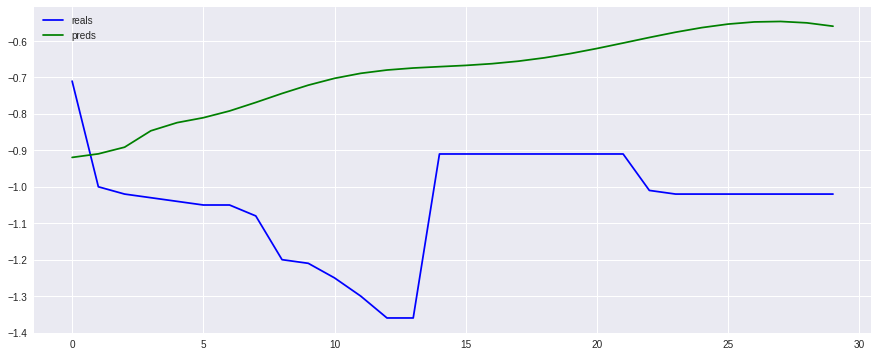

In [66]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

## GRU cell - with EOS = 1000 - 50 epochs

In [69]:
rnn_cell = PriceHistorySeq2Seq.RNN_CELLS.GRU
num_epochs = 50
num_epochs, num_units, batch_size

(50, 400, 47)

In [70]:
def experiment():
    return model.run(
        npz_path=npz_path,
        epochs=num_epochs,
        batch_size=batch_size,
        num_units=num_units,
        input_len = input_len,
        target_len = target_len,
        rnn_cell=rnn_cell,
    )

In [71]:
#dyn_stats = experiment()
dyn_stats, preds_dict = get_or_run_nn(experiment, filename='006_gru_seq2seq_EOS1000_50epochs_60to30')

time: Tensor("decoder_rnn_layer/rnn/while/add:0", shape=(), dtype=int32)

epochs: 50
End Epoch 01 (53.977 secs): err(train) = 5.8005
End Epoch 02 (53.335 secs): err(train) = 4.7390
End Epoch 03 (53.319 secs): err(train) = 4.5466
End Epoch 04 (53.376 secs): err(train) = 4.3279
End Epoch 05 (53.349 secs): err(train) = 4.1670
End Epoch 06 (53.292 secs): err(train) = 4.2144
End Epoch 07 (53.300 secs): err(train) = 3.9278
End Epoch 08 (53.326 secs): err(train) = 3.7943
End Epoch 09 (53.449 secs): err(train) = 3.6943
End Epoch 10 (53.322 secs): err(train) = 3.5751
End Epoch 11 (53.257 secs): err(train) = 3.3962
End Epoch 12 (53.296 secs): err(train) = 3.2182
End Epoch 13 (53.300 secs): err(train) = 3.1631
End Epoch 14 (53.274 secs): err(train) = 3.0615
End Epoch 15 (53.334 secs): err(train) = 2.8963
End Epoch 16 (53.289 secs): err(train) = 2.8134
End Epoch 17 (53.260 secs): err(train) = 2.7348
End Epoch 18 (53.315 secs): err(train) = 2.5920
End Epoch 19 (53.307 secs): err(train) = 2.5298
End

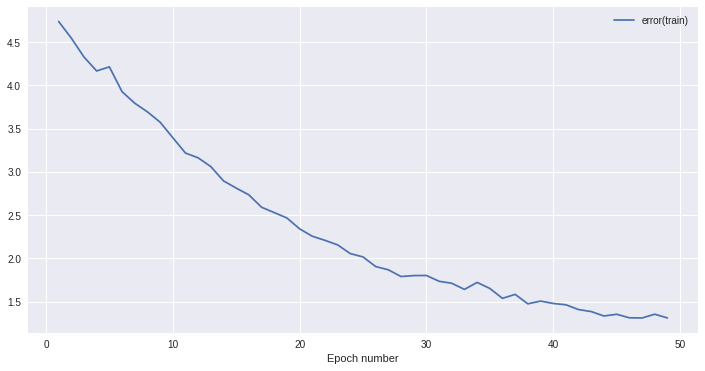

In [72]:
dyn_stats.plotStats()
plt.show()

In [73]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [74]:
ind = np.argmin(r2_scores)
ind

2685

In [75]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [76]:
r2_score(y_true=reals, y_pred=preds)

-1.6173924856677622e+30

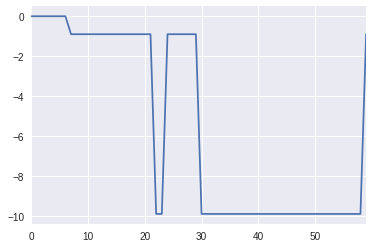

In [77]:
sns.tsplot(data=dp.inputs[ind].flatten())

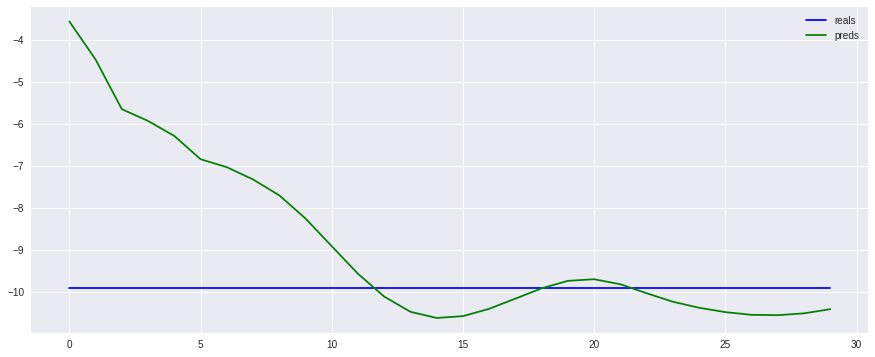

In [78]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [79]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 24.1 s, sys: 172 ms, total: 24.3 s
Wall time: 24.1 s


In [80]:
np.mean(dtw_scores)

41.109554412327384

In [81]:
coint(preds, reals)

(-0.28076966594524172,
 0.97674728254986654,
 array([-4.31395736, -3.55493606, -3.19393252]))

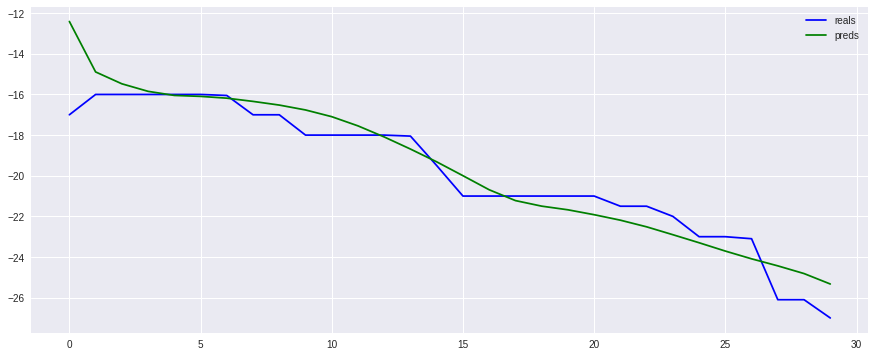

In [114]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

#### Conclusion
???